# Indexation Web - TP1
BERNARD Renan

## Introduction

Tout d'abord les différentes importations nécessaires pour ce Notebook.
Les fonctions utilisées sont dans le fichier __utils.py__.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from functools import reduce
import multiprocessing

from utils import *

[nltk_data] Downloading package stopwords to /home/renan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Récupérons ensuite l'ensemble des données. Nous garderons un DataFrame contenons le texte, l'auteur et l'identifiant du document.

In [4]:
%%time
texts = generate_texts_dataframe()
texts.head()

CPU times: user 103 ms, sys: 51.5 ms, total: 154 ms
Wall time: 429 ms


,Text,Author,DocumentId
0,"Russia's Fuel and Energy Ministry, sitting on ...",Lynnley Browning,116673
1,Russia's Western oil joint ventures are findin...,Lynnley Browning,248885
2,Russian oil company officials said on Friday t...,Lynnley Browning,314644
3,Azerbaijan is proving more successful in attra...,Lynnley Browning,219830
4,A multinational group trying to build a $1.5 b...,Lynnley Browning,239689


Lisons un article :

In [5]:
view_article(1380, texts)


--------------------------------------------
Author : William Kazer
Id : 209813
--------------------------------------------
Russia will push to expand economic ties with China at a top level meeting in Moscow next month as old political hostilities fade in the background, a senior Russian diplomat said on Friday.
"The big task in bilateral relations is to boost economic cooperation to the level of political cooperation," said Russian Ambassador Igor Rogachev.
Chinese Premier Li Peng and Russian Prime Minister Viktor Chernomyrdin will meet in Moscow to map out practical economic steps in a relationship described by the two sides as a strategic partnership.
The two former rivals for the leadership of the world communist movement have not seen such smooth relations since 1949 -- when the Chinese communists proclaimed the birth of the People's Republic of China, according to the Russian diplomat.
"Relations have never been on such a healthy and rational basis," said Rogachev, one of Russ

## Préparation des Textes - _Tokenization_

Le premier traitement est la transformation des phrases en une liste de mots contenant uniquement des caractères alphabétiques minuscules extraits à l'aide d'une expression régulière.

On enlève ensuite les 'stopWords' (_the_, _a_, _or_,...) qui n'apportent pas d'information sur le contenu de l'article.

Puis on a choisi d'utiliser un __stemmer__ pour transformer les mots en _tokens_. Cette méthode enlève les préfixes et suffixes des mots pour garder uniquement la racine. Celle-ci n'est pas forcement un mot qui existe réellement comme _ministri_, mais capte l'ensemble des mots "proches".

C'est la fonction __tokenize_text__ qui fait cette étape. Elle est présente dans __utils.py__.

La suite du traitement de texte se fera via ces listes de _tokens_.

## Indexation

### Création de l'Index

Afin de trouver rapidement les documents qui contiennent un certain _token_, nous créons un index. On a choisi de faire un index de la forme suivante :

In [ ]:
{"token1" : {"total_occurences" : 4,
             article1 : {"locations" : [12, 13, 14],
                         "occurences" : 3},
             article2 : {"locations" : [9],
                         "occurences" : 1}}}

La création de l'index pour un seul texte se fait via la fonction __create_index_from_text__. Celle-ci procède via une itération sur la liste de _tokens_ correspondant au texte pour ensuite enregistrer le nombre d'occurences des _tokens_ dans un index selon le modèle précédent.

La création de l'index final se fait alors en "additionant" les différents index via la foncion __sum_two_indexes__.
                               
Tout d'abord, regardons le temps d'exécution et le résultat via une itération sur l'ensemble des documents :

In [6]:
%%time
index = create_index_from_text(texts.Text[0], 0)
for i in range(1, len(texts)):
    index_i = create_index_from_text(texts.Text[i], i)
    index = sum_two_indexes(index, index_i)

CPU times: user 16.8 s, sys: 98 ms, total: 16.9 s
Wall time: 16.9 s


In [7]:
index['ministri']

{'total_occurences': 361,
 0: {'locations': [3, 64, 104, 146, 154, 197, 228, 315, 344, 352],
  'occurences': 10},
 2: {'locations': [91, 108], 'occurences': 2},
 3: {'locations': [228, 245], 'occurences': 2},
 7: {'locations': [142], 'occurences': 1},
 12: {'locations': [212], 'occurences': 1},
 13: {'locations': [2, 35, 60], 'occurences': 3},
 14: {'locations': [170, 269], 'occurences': 2},
 16: {'locations': [212, 295], 'occurences': 2},
 23: {'locations': [11, 55, 200, 203, 250], 'occurences': 5},
 25: {'locations': [233, 296, 311, 329], 'occurences': 4},
 26: {'locations': [142], 'occurences': 1},
 32: {'locations': [329], 'occurences': 1},
 33: {'locations': [115], 'occurences': 1},
 37: {'locations': [130, 228, 311], 'occurences': 3},
 41: {'locations': [30, 65, 77], 'occurences': 3},
 45: {'locations': [98], 'occurences': 1},
 46: {'locations': [226, 244], 'occurences': 2},
 47: {'locations': [130], 'occurences': 1},
 48: {'locations': [129], 'occurences': 1},
 82: {'locations':

Maintenant essayons avec l'architecture __MapReduce__, le _mapper_ correspondant à la création de l'index sur un seul text, le _reducer_ correspondant à la somme de deux index.

In [8]:
%%time 
def mapper(x):
    return create_index_from_text(texts.Text[x], x)

with multiprocessing.Pool(processes=4) as pool:
        results = pool.map(mapper, range(len(texts)))
        
index = reduce(sum_two_indexes, list(results))

CPU times: user 2.79 s, sys: 216 ms, total: 3.01 s
Wall time: 10.9 s


In [9]:
index['ministri']

{'total_occurences': 361,
 0: {'locations': [3, 64, 104, 146, 154, 197, 228, 315, 344, 352],
  'occurences': 10},
 2: {'locations': [91, 108], 'occurences': 2},
 3: {'locations': [228, 245], 'occurences': 2},
 7: {'locations': [142], 'occurences': 1},
 12: {'locations': [212], 'occurences': 1},
 13: {'locations': [2, 35, 60], 'occurences': 3},
 14: {'locations': [170, 269], 'occurences': 2},
 16: {'locations': [212, 295], 'occurences': 2},
 23: {'locations': [11, 55, 200, 203, 250], 'occurences': 5},
 25: {'locations': [233, 296, 311, 329], 'occurences': 4},
 26: {'locations': [142], 'occurences': 1},
 32: {'locations': [329], 'occurences': 1},
 33: {'locations': [115], 'occurences': 1},
 37: {'locations': [130, 228, 311], 'occurences': 3},
 41: {'locations': [30, 65, 77], 'occurences': 3},
 45: {'locations': [98], 'occurences': 1},
 46: {'locations': [226, 244], 'occurences': 2},
 47: {'locations': [130], 'occurences': 1},
 48: {'locations': [129], 'occurences': 1},
 82: {'locations':

Les résultats sont heureusement les mêmes, mais l'utilisation de __map__ et __reduce__ divise par quasiment 2 le temps de calcul (en fonction de la RAM de la machine, on peut augmenter le nombre de _processes_).

### Etude du Vocabulaire

In [10]:
%%time

def mapper(token):
    return {"Token" : token, "Occurences" : index[token]["total_occurences"]}

with multiprocessing.Pool(processes=4) as pool:
        results = pool.map(mapper, list(index.keys()))
        
df_vocabulary = pd.DataFrame(list(results)).sort_values("Occurences", ascending=False)

CPU times: user 94.2 ms, sys: 244 ms, total: 338 ms
Wall time: 493 ms


In [11]:
df_vocabulary.head()

,Token,Occurences
17,said,19856
277,year,7025
79,compani,5658
304,percent,5296
375,would,5202


Le _token_ le plus utilisé dans le corpus est __said__, puis __year__. Ces mots auraient pû être considérés comme des __stopWords__ (non-porteurs de sens) vu leur fréquence.

La loi de __Zipf__ est-elle vérifiée dans notre corpus ?

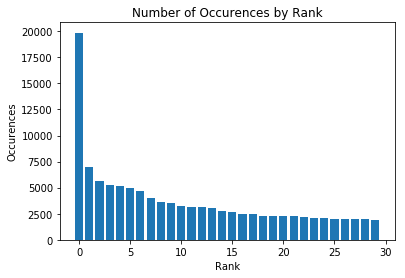

In [12]:
plt.bar(x=range(30), height=df_vocabulary.Occurences[:30])
plt.xlabel("Rank")
plt.ylabel("Occurences")
plt.title("Number of Occurences by Rank")
plt.show()

On peut voir la loi de __Zipf__ si on veut la voir. Le corpus étant d'une taille assez limitée (2500 textes), on peut supposer qu'il est normal d'avoir quelque chose de proche. Il est aussi important de rappeler que nous travaillons sur des _tokens_ et non des mots !

## _Ranking_ par occurences

Tout d'abord un schéma de requêtes simples : pour une phrase ou un mot, les documents sont ordonnées par leur nombre de _tokens_ total. Pour la requête __"china"__, les documents seront classés par leur nombre d'occurences du _token_ __china__. Pour la requête __"china and russia were communist"__, les documents seront classés par leur nombre d'occurences total des _tokens_ __china__, __russia__ et __communist__.

In [13]:
query = "china"
query_by_occurences(query, index, texts).head()

,china,Total,Text,Author,DocumentId
1565,26,26.0,While China's leaders peppered 1996 with assur...,Lynne Donnell,275670
2294,24,24.0,"Now that China's Deng Xiaoping is dead, Hong K...",Sarah Davison,405565
170,21,21.0,More foreign firms are finally beginning to re...,Graham Earnshaw,277010
1198,20,20.0,China is unlikely to concede on its demand to ...,Jane Macartney,242319
1150,20,20.0,China is unlikely to concede on its demand to ...,Jane Macartney,242519


In [14]:
query = "china and russia"
query_by_occurences(query, index, texts).head()

,china,russia,Total,Text,Author,DocumentId
1380,15,10,25.0,Russia will push to expand economic ties with ...,William Kazer,209813
1165,10,7,17.0,China on Sunday hailed a brief visit by Premie...,Jane Macartney,279477
1552,13,3,16.0,China's decision to ban imports of some U.S. c...,Lynne Donnell,112106
1595,13,2,15.0,Demand is the engine that will drive China's m...,Lynne Donnell,265681
1189,14,1,15.0,China hopes for a breakthrough to launch manne...,Jane Macartney,156668


Maintenant plus compliqué : repondons à une requête en respectant l'ordre des mots, les résutats seront classés de la même manière que les requêtes précédentes.

In [15]:
%%time
query = "air cargo"
query_by_ordered_occurences(query, index, texts).head()

CPU times: user 48.1 ms, sys: 1e+03 ns, total: 48.1 ms
Wall time: 47.6 ms


,Occurences,Text,Author,DocumentId
1330,12,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
1347,12,An American airline has successfully completed...,Jim Gilchrist,206567
1305,10,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
936,9,French aviation executives said on Tuesday the...,Pierre Tran,117510
1328,6,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504


## _Ranking_ par Fréquences

Passons à un schéma de requêtes plus cohérent : en utilisant la fréquence des mots au sein d'un document.

In [20]:
%%time
query = "bank crash"
df = query_by_frequences(query, index, texts)
df

CPU times: user 423 ms, sys: 4.09 ms, total: 427 ms
Wall time: 426 ms


,bank,crash,Total,Text,Author,DocumentId
1435,0.0309278,0.00515464,0.036082,The Toronto Stock Exchange's key 300 Index rea...,Darren Schuettler,156181
2196,0.0234192,0.00468384,0.028103,Federal Reserve Chairman Alan Greenspan on Fri...,Aaron Pressman,394237
168,0.00682594,0.00341297,0.010239,Last week's stern crackdown on China's stock m...,Graham Earnshaw,273087
154,0.00653595,0.00326797,0.009804,Last week's stern crackdown on China's stock m...,Graham Earnshaw,274219
1373,0.00330033,0.00330033,0.006601,China has taken its cue from U.S. Federal Rese...,William Kazer,258689
86,0.00295858,0.00295858,0.005917,"The world's biggest mining house, RTZ Corp Plc...",Mark Bendeich,402412
89,0.00289017,0.00289017,0.005780,"The world's biggest mining house, RTZ Corp Plc...",Mark Bendeich,402409


## _Ranking_ par TF-IDF

In [21]:
%%time
query = "air france"
query_by_tfidf(query, index, texts)

CPU times: user 480 ms, sys: 138 µs, total: 480 ms
Wall time: 483 ms


,air,franc,Total,Text,Author,DocumentId
1291,0.158061,0.105181,0.097315,French state-owned Air France said on Thursday...,Marcel Michelson,140849
1258,0.148711,0.110678,0.096045,French state-owned airline Air France said on ...,Marcel Michelson,141744
1276,0.148292,0.110366,0.095775,French state-owned airline Air France said on ...,Marcel Michelson,141746
1263,0.152342,0.0987354,0.092784,French state-owned Air France said on Thursday...,Marcel Michelson,140842
948,0.0825959,0.162808,0.092141,State-owned Air France on Wednesday reported d...,Pierre Tran,204524
919,0.0825959,0.162808,0.092141,State-owned Air France on Wednesday reported d...,Pierre Tran,203527
936,0.118182,0.123791,0.090047,French aviation executives said on Tuesday the...,Pierre Tran,117510
941,0.107392,0.131612,0.089147,Air France on Wednesday ordered 10 Boeing jetl...,Pierre Tran,203401
939,0.11221,0.113919,0.084112,Air France is linking up with two major U.S. c...,Pierre Tran,120914
907,0.116487,0.109814,0.084084,Air France is linking up with two major U.S. c...,Pierre Tran,121060


## Représentation vectorielle avec TF-IFD

La matrice TF_IDF (la représation du corpus dans l'espace TF-IDF) est également créer suivant un modèle _MapReduce_, le __mapper__ étant le calcul du TF-IDF pour chaque documents d'un _token_, le __reducer__ étant une simple concaténation.

In [22]:
%%time
tf_idf_matrix = calculate_tf_idf_matrix(index, texts)

CPU times: user 625 ms, sys: 168 ms, total: 793 ms
Wall time: 803 ms


### Mise en place d'une requête du corpus

Pour requêter (_query_) le corpus, nous calculons simplement le produit scalaire (_dot product_) de la représentation du texte de la requête dans l'espace TF-IDF par la matrice correspondant aux repréentations des documents. Le document dont le _dot product_ est le plus élevé, est le plus pertinent, etc.

In [27]:
%%time
query_corpus("air france", index, tf_idf_matrix, texts, nb_to_show=20)

CPU times: user 209 ms, sys: 202 µs, total: 209 ms
Wall time: 170 ms


,DotProduct,Text,Author,DocumentId
1258,0.177941,French state-owned airline Air France said on ...,Marcel Michelson,141744
1276,0.177941,French state-owned airline Air France said on ...,Marcel Michelson,141746
1279,0.163607,"The 1,400 staff of ailing French regional airl...",Marcel Michelson,129351
1295,0.157188,"The 1,400 staff of ailing French regional airl...",Marcel Michelson,129426
948,0.156448,State-owned Air France on Wednesday reported d...,Pierre Tran,204524
919,0.156448,State-owned Air France on Wednesday reported d...,Pierre Tran,203527
1291,0.153906,French state-owned Air France said on Thursday...,Marcel Michelson,140849
1290,0.149128,British Airways Plc (BA) on Wednesday boosted ...,Marcel Michelson,137480
1274,0.145396,British Airways Plc on Wednesday joined with F...,Marcel Michelson,137362
1252,0.145396,British Airways Plc (BA) on Wednesday boosted ...,Marcel Michelson,137247
